In [6]:
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from collections import defaultdict
import random

In [3]:
with open("data.pkl", "rb") as f:
    data = pickle.load(f)

with open("labels.pkl", "rb") as f:
    
    labels = pickle.load(f)

print("loaded data")

loaded data


In [3]:
print(len(data), len(labels))

81450 81450


In [92]:
# seperate data into buckets of size 25

bucket_size = 25
min_samples = 1                  
overrepresented_range = (225, 350)
overrepresented_range2 = (350, 550)
cap_samples = 700              

bucketed_data = defaultdict(list)
for i in range(len(data)):
    move_count = labels[i] 
    bucket_key = int(move_count // bucket_size) * bucket_size
    bucketed_data[bucket_key].append((data[i], move_count))

# split data into train and test
x_train, y_train = [], []
x_test, y_test = [], []

for bucket in sorted(bucketed_data):
    samples = bucketed_data[bucket]
    if len(samples) < min_samples:
        continue
    
    # cap overrepresented buckets
    if overrepresented_range[0] <= bucket <= overrepresented_range[1]:
        samples = samples[:min(len(samples), cap_samples)]  
    if overrepresented_range2[0] <= bucket <= overrepresented_range2[1]:
        samples = samples[:min(len(samples), 500)]
        
    random.shuffle(samples)
    split = int(0.8 * len(samples))

    x_train += [s[0] for s in samples[:split]]
    y_train += [s[1] for s in samples[:split]]
    x_test  += [s[0] for s in samples[split:]]
    y_test  += [s[1] for s in samples[split:]]


In [85]:
# create train and test tensor to feed into model
X_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
Y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)
Y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [94]:
# define model architecture
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 15 * 15, 128)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))      
        x = self.pool(F.relu(self.conv2(x))) 
        x = F.relu(self.conv3(x))       
        x = x.view(x.size(0), -1)       
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [95]:
# initialize model, optimizer, and criterion
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 8

In [96]:
# train model
from tqdm import tqdm

model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1: 100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 1/8, Loss: 21337.8552


Epoch 2: 100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 2/8, Loss: 7868.7414


Epoch 3: 100%|██████████| 101/101 [00:08<00:00, 12.01it/s]


Epoch 3/8, Loss: 6195.3316


Epoch 4: 100%|██████████| 101/101 [00:08<00:00, 11.78it/s]


Epoch 4/8, Loss: 4478.6797


Epoch 5: 100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 5/8, Loss: 3916.7550


Epoch 6: 100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 6/8, Loss: 3713.3201


Epoch 7: 100%|██████████| 101/101 [00:08<00:00, 11.71it/s]


Epoch 7/8, Loss: 3418.7936


Epoch 8: 100%|██████████| 101/101 [00:08<00:00, 12.00it/s]

Epoch 8/8, Loss: 3274.7402


In [93]:
# calculate test loss

from tqdm import tqdm
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc=f"test"):
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()
        

avg_test_loss = test_loss / len(test_loader)
print(f"Average Test Loss: {avg_test_loss:.4f}")


test: 100%|██████████| 70/70 [00:03<00:00, 19.87it/s]

Average Test Loss: 4145.8970


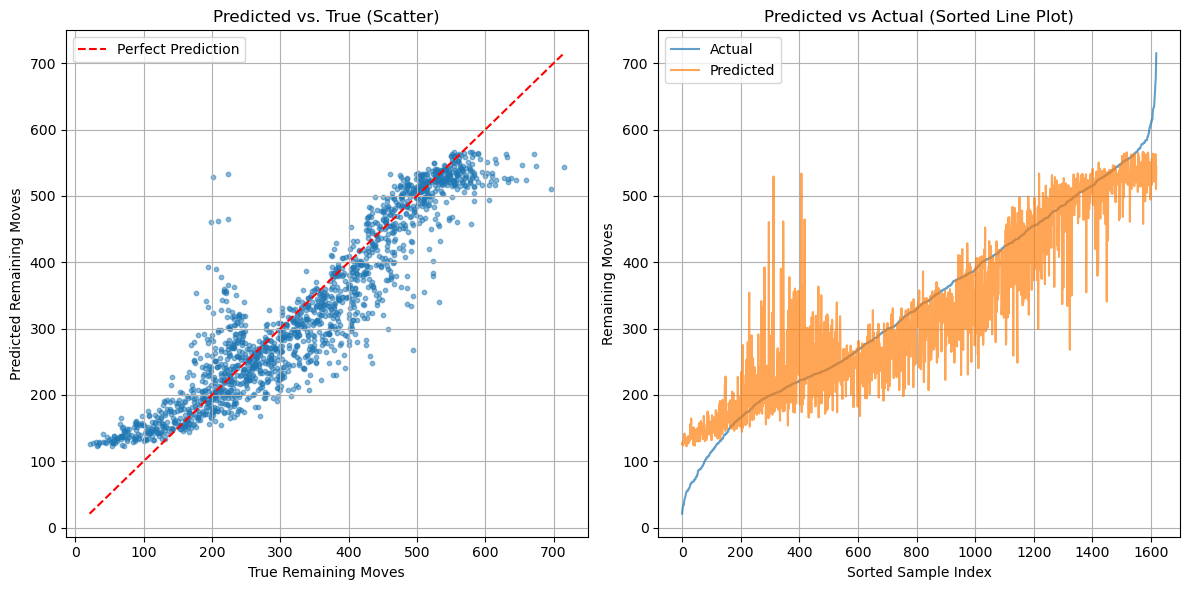

In [97]:
# evaluate model and plot results
model.eval()
predictions = []
true_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        outputs = outputs.squeeze()


        predictions.extend(outputs.tolist())
        true_values.extend(targets.tolist())



plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(true_values, predictions, alpha=0.5, s=10)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', label="Perfect Prediction")
plt.xlabel("True Remaining Moves")
plt.ylabel("Predicted Remaining Moves")
plt.title("Predicted vs. True (Scatter)")
plt.legend()
plt.grid(True)

true_tensor = torch.tensor(true_values)
pred_tensor = torch.tensor(predictions)
sorted_indices = torch.argsort(true_tensor)
y_true_sorted = true_tensor[sorted_indices]
y_pred_sorted = pred_tensor[sorted_indices]

plt.subplot(1, 2, 2)
plt.plot(y_true_sorted, label="Actual", alpha=0.7)
plt.plot(y_pred_sorted, label="Predicted", alpha=0.7)
plt.xlabel("Sorted Sample Index")
plt.ylabel("Remaining Moves")
plt.title("Predicted vs Actual (Sorted Line Plot)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

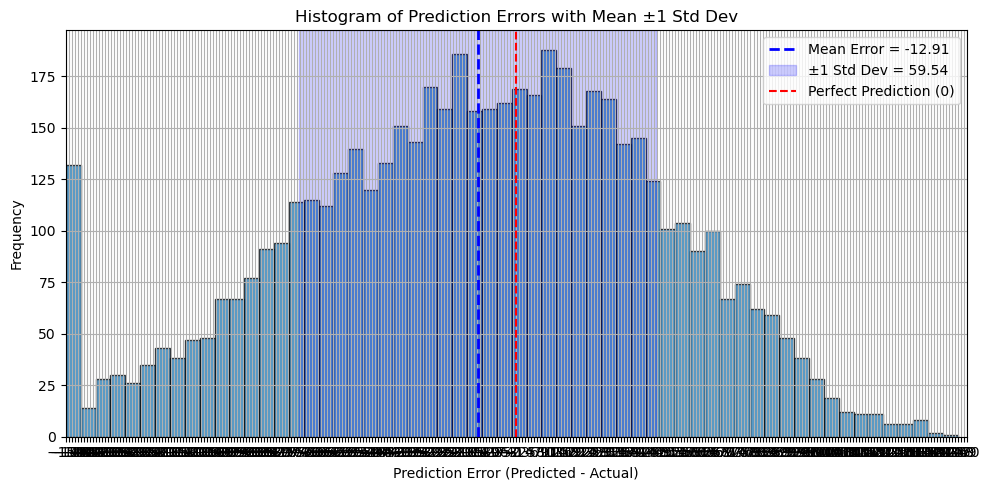

In [35]:
# plot error histogram

import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_error_histogram_with_stats(true_values, predictions, bins=60):
    true_tensor = torch.tensor(true_values)
    pred_tensor = torch.tensor(predictions)
    
    errors = (pred_tensor - true_tensor).numpy()
    clipped_errors = np.clip(errors, -150, 150)

    mean_error = np.mean(clipped_errors)
    std_error = np.std(clipped_errors)

    plt.figure(figsize=(10, 5))
    plt.hist(clipped_errors, bins=bins, edgecolor='black', alpha=0.75)

    plt.axvline(mean_error, color='blue', linestyle='--', linewidth=2, label=f"Mean Error = {mean_error:.2f}")

    plt.axvspan(mean_error - std_error, mean_error + std_error, color='blue', alpha=0.2, label=f"±1 Std Dev = {std_error:.2f}")

    plt.axvline(0, color='red', linestyle='--', label='Perfect Prediction (0)')

    plt.xlim(-150, 150)
    plt.xticks(np.arange(-150, 151, 1))
    plt.xlabel("Prediction Error (Predicted - Actual)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Prediction Errors with Mean ±1 Std Dev")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_error_histogram_with_stats(true_values, predictions)


<Figure size 1200x500 with 0 Axes>

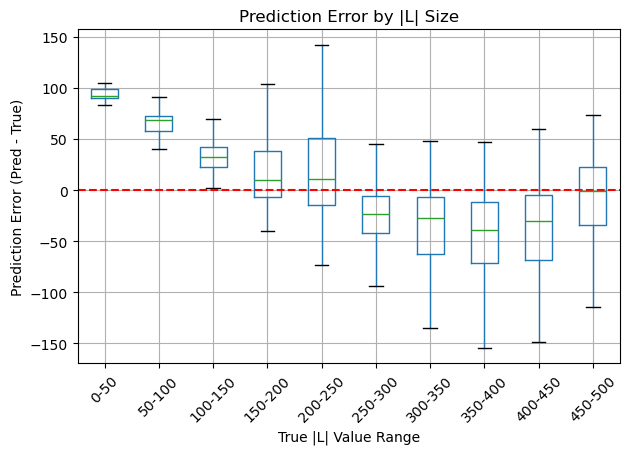

In [98]:
# plot a box plot of the error by the L value

import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd

def plot_error_by_L_bin(true_values, predictions, bin_size=50, max_L=500):
    true_vals = torch.tensor(true_values).numpy()
    pred_vals = torch.tensor(predictions).numpy()
    errors = pred_vals - true_vals

    bins = list(range(0, max_L + bin_size, bin_size)) 
    labels = [f"{b}-{b+bin_size}" for b in bins[:-1]]
    df = pd.DataFrame({'L': true_vals, 'Error': errors})
    df['Bin'] = pd.cut(df['L'], bins=bins, labels=labels, right=False)

    plt.figure(figsize=(12, 5))
    df.boxplot(column='Error', by='Bin', grid=True, showfliers=False)
    plt.title("Prediction Error by |L| Size")
    plt.suptitle("")
    plt.xlabel("True |L| Value Range")
    plt.ylabel("Prediction Error (Pred - True)")
    plt.xticks(rotation=45)
    plt.axhline(0, color='red', linestyle='--')
    plt.tight_layout()
    plt.show()

plot_error_by_L_bin(true_values, predictions)



In [99]:
# save model
torch.save(model.state_dict(), "model_weights.pth")